In [45]:
!pip install opencv-python-headless

In [62]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# cv2.imshow()
from google.colab.patches import cv2_imshow



In [ ]:
# precomputed mean and stddev
mean_gray = 0.1307
stddev_gray = 0.3081

# Transform the images to tensors
transforms_original = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((mean_gray,), (stddev_gray,))])
transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])



# Load Dataset

In [ ]:
train_dataset = datasets.MNIST(root = './data',
                               train= True,
                               transform =  transforms_original,
                               download =  True)
test_dataset =  datasets.MNIST(root = './data',
                               train = False,
                               transform = transforms_original)

# Random Image

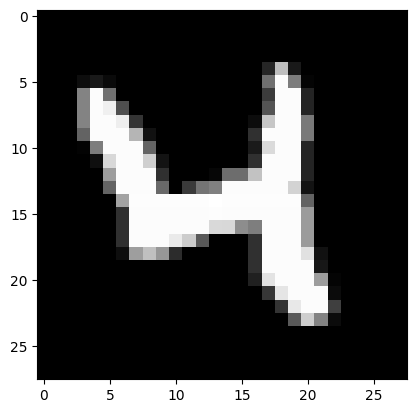

In [ ]:
import matplotlib.pyplot as plt

# Data
random_image = train_dataset[20][0].numpy()*stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28),cmap='gray')

In [ ]:
# Label
print(train_dataset[20][1])

4


In [ ]:
# Iterable Dataset

batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size = batch_size,
                                          shuffle=False)

In [ ]:
len(train_dataset)

60000

In [ ]:
len(train_loader)

600

In [ ]:
60000/100

In [23]:
print('Training Set (images) : {}' .format(len(train_dataset)))
print('Test Set (images) : {}' .format(len(test_dataset)))

print('Train Loader Batches : {}' .format(len(train_loader)))
print('Test Loader Batches : {}' .format(len(test_loader)))

Training Set (images) : 60000
Test Set (images) : 10000
Train Loader Batches : 600
Test Loader Batches : 100


# Model Class

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)

    def forward(self, x):
        x = self.cnn1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.batchnorm2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [28]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
  model=model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [29]:
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_loader):

    CUDA = torch.cuda.is_available()
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()

    print("Her bir iterasyonda...")
    print("Input Shape:", inputs.shape)
    print("Labels Shape:", labels.shape)
    output = model(inputs)
    print("Output Shape : ", output.shape)  # Burayı düzelttik
    _, predicted = torch.max(output, 1)
    print("Predicted Shape:", predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    break


Her bir iterasyonda...
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Output Shape :  torch.Size([100, 10])
Predicted Shape: torch.Size([100])
Predicted Tensor:
tensor([6, 7, 8, 3, 6, 6, 6, 4, 0, 7, 7, 7, 6, 0, 7, 4, 0, 8, 8, 8, 8, 2, 3, 6,
        6, 2, 3, 6, 6, 6, 6, 8, 6, 4, 7, 6, 6, 2, 7, 3, 7, 3, 2, 7, 3, 7, 6, 0,
        6, 0, 2, 3, 4, 6, 8, 8, 6, 6, 6, 6, 8, 7, 2, 8, 2, 0, 6, 6, 7, 4, 7, 7,
        6, 3, 3, 6, 6, 0, 8, 6, 6, 8, 8, 3, 4, 8, 5, 4, 2, 6, 3, 2, 6, 6, 7, 0,
        8, 7, 6, 6])


# Training the Model

In [32]:
num_epochs = 25

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):

  correct = 0
  iterations = 0
  iter_loss = 0.0

  model.train()

  for i, (inputs, labels) in enumerate(train_loader):

    CUDA = torch.cuda.is_available()
    if CUDA:
      inputs = inputs.cuda()
      labels=labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    iter_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()     # update the weights

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    iterations += 1

  train_loss.append(iter_loss/iterations)
  train_accuracy.append((100*correct/len(train_dataset)))

  testing_loss = 0.0
  correct = 0
  iterations = 0

  model.eval()        # NN evaluation mode'a sok

  for i, (inputs, labels) in enumerate(test_loader):

    CUDA = torch.cuda.is_available()
    if CUDA:
      inputs = inputs.cuda()
      labels=labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    testing_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    iterations += 1

  test_loss.append(testing_loss/iterations)
  test_accuracy.append((100*correct/len(test_dataset)))

  print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))



Epoch 1/25, Training Loss: 0.137, Training Accuracy: 95.873, Testing Loss: 0.078, Testing Acc: 97.660
Epoch 2/25, Training Loss: 0.117, Training Accuracy: 96.415, Testing Loss: 0.065, Testing Acc: 97.940
Epoch 3/25, Training Loss: 0.105, Training Accuracy: 96.740, Testing Loss: 0.060, Testing Acc: 98.130
Epoch 4/25, Training Loss: 0.096, Training Accuracy: 97.075, Testing Loss: 0.054, Testing Acc: 98.260
Epoch 5/25, Training Loss: 0.088, Training Accuracy: 97.250, Testing Loss: 0.050, Testing Acc: 98.440
Epoch 6/25, Training Loss: 0.083, Training Accuracy: 97.435, Testing Loss: 0.046, Testing Acc: 98.540
Epoch 7/25, Training Loss: 0.078, Training Accuracy: 97.587, Testing Loss: 0.045, Testing Acc: 98.560
Epoch 8/25, Training Loss: 0.073, Training Accuracy: 97.718, Testing Loss: 0.042, Testing Acc: 98.650
Epoch 9/25, Training Loss: 0.070, Training Accuracy: 97.878, Testing Loss: 0.040, Testing Acc: 98.600
Epoch 10/25, Training Loss: 0.068, Training Accuracy: 97.850, Testing Loss: 0.037,

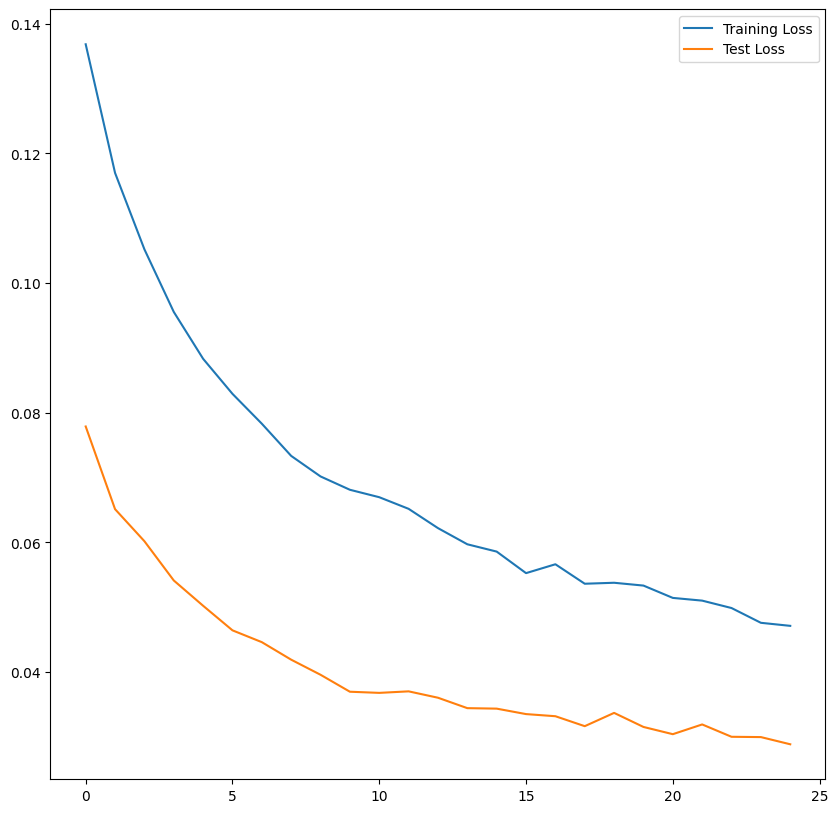

In [33]:
# Plotting the Loss
fig=plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.show()

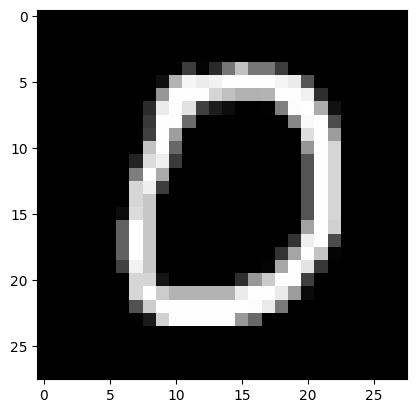

In [35]:
plt.imshow(test_dataset[10][0].reshape(28,28), cmap='gray')

In [71]:
def predict(img_name, model):
    # Resmi oku
    image = cv2.imread(img_name, 0)
    if image is None:
        raise FileNotFoundError(f"{img_name} dosyası bulunamadı.")

    # Görüntüyü 28x28 boyutlarına küçült
    image_resized = cv2.resize(image, (28, 28))

    # Görüntü işleme (binarize etme)
    ret, thresholded = cv2.threshold(image_resized, 127, 255, cv2.THRESH_BINARY)
    img = 255 - thresholded  # Siyah beyaz ters çevrildi

    # Görüntüyü göster
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # PyTorch tensörüne dönüştür ve boyutları düzenle
    img = Image.fromarray(img)
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img).unsqueeze(0)  # 1x1x28x28 formatında (batch_size, channels, height, width)

    # Modelin doğru çalışabilmesi için CUDA'ya taşı
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    # Model tahminini yap
    output = model(img)
    _, predicted = torch.max(output, 1)

    return predicted.item()

# Tahmin
prediction = predict('uc.png', model)
print(f"Tahmin edilen Label: {prediction}")

Tahmin edilen Label: 1


In [61]:
# Görüntü ve etikete erişim
img, label = test_dataset[12]

# Resize işlemi (PyTorch Tensors)
img = img.unsqueeze(0)  # Batch boyutunu ekler: (1, C, H, W)

# Model değerlendirme modunda
model.eval()

# CUDA kontrolü
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
    img = img.cuda()

# Modelden tahmin alma
output = model(img)
_, predicted = torch.max(output, 1)

# Tahmin ve gerçek etiketi yazdırma
print(f"Tahmin edilen label: {predicted.item()}")
print(f"Gerçek label: {label}")


Tahmin edilen label: 9
Gerçek label: 9
